In [1]:
import numpy as np
import torch
import random
import copy
import matplotlib.pyplot as plt

In [2]:
from load_data import *

In [3]:
X_tr, X_te, y_tr, y_te, xs_tr, xs_te = load_compas_data(svm=False,random_state=42)


Number of people recidivating within two years
0    2795
1    2483
dtype: int64




In [4]:
def poison_Z(xs,pos_rt = 0.1, rs = 3):
    n_pos = int(len(xs)*pos_rt)
    random.seed(rs)
    r_idxs = list(range(len(xs)))
    random.shuffle(r_idxs)
    xsp = copy.deepcopy(xs)
    xsp[r_idxs[:n_pos]] = 1-xs_tr[r_idxs[:n_pos]]
    return xsp

In [5]:
from fairNN_train import *

In [6]:
xs_tep =  poison_Z(xs_te,pos_rt = 0.1, rs = 3)

In [7]:
train_loader, test_loader = make_dataloaders(X_tr, X_te, y_tr, y_te, xs_tr, xs_te)
# _, testp_loader = make_dataloaders(X_tr, X_te, y_tr, y_te, xs_tr, xs_tep)

In [8]:
n_features = train_loader.dataset.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [9]:
pretrain_NN(clf,train_loader,clf_criterion,clf_optimizer, n_epoch = 5)

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Classifier(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [10]:
lambdas = torch.Tensor([30])
adv = Adversary(xs_tr.shape[1])
adv_criterion = nn.BCELoss(reduce=False)
adv_optimizer = optim.Adam(adv.parameters())

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
pretrain_adv(clf,adv,train_loader,adv_criterion,adv_optimizer,lambdas, n_epoch = 5)

Adversary(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [12]:
clf, adv = train_FNN(clf, adv, train_loader,test_loader, clf_criterion, adv_criterion,clf_optimizer,adv_optimizer, lambdas, n_epoch = 30)

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


test for epoch: 1
Overall accuracy: 0.6300505050505051
disparate impact:  30.92316488542903
disparate misclassification rate:  58.156130096460714
disparate false positive rate: 32.58461932743881
disparate false negative rate: 53.04154454715009
equalized opportunity for 0.0 : 32.58461932743881
equalized opportunity for 1.0 : 34.97516673761884
loss function:  bce_loss
loss value for group 0: 0.6459747552871704
loss value for group 1: 0.6260395050048828
test for epoch: 2
Overall accuracy: 0.6231060606060606
disparate impact:  31.22694213133762
disparate misclassification rate:  61.54409457056177
disparate false positive rate: 30.3298800436205
disparate false negative rate: 62.705584673775526
equalized opportunity for 0.0 : 30.3298800436205
equalized opportunity for 1.0 : 37.86510087323095
loss function:  bce_loss
loss value for group 0: 0.659345269203186
loss value for group 1: 0.6340702176094055
test for epoch: 3
Overall accuracy: 0.6117424242424242
disparate impact:  34.67636268343816
d

test for epoch: 18
Overall accuracy: 0.57260101010101
disparate impact:  57.50452079566003
disparate misclassification rate:  80.99492961741657
disparate false positive rate: 34.344569288389515
disparate false negative rate: 88.64516249988283
equalized opportunity for 0.0 : 34.344569288389515
equalized opportunity for 1.0 : 56.21543466473884
loss function:  bce_loss
loss value for group 0: 0.750087320804596
loss value for group 1: 0.6261236667633057
test for epoch: 19
Overall accuracy: 0.5688131313131313
disparate impact:  44.89017125837677
disparate misclassification rate:  85.6794265670276
disparate false positive rate: 30.40338920611531
disparate false negative rate: 80.31249109001226
equalized opportunity for 0.0 : 30.40338920611531
equalized opportunity for 1.0 : 45.089463220675945
loss function:  bce_loss
loss value for group 0: 0.7286678552627563
loss value for group 1: 0.629289448261261
test for epoch: 20
Overall accuracy: 0.57260101010101
disparate impact:  50.450632911392404


1584
poisoned ratio:  0.0


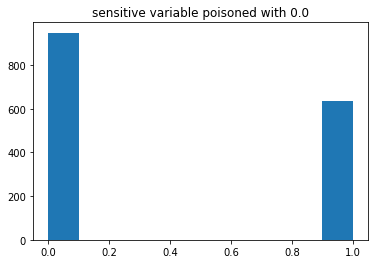

Overall accuracy: 0.625
disparate impact:  67.63361316598787
disparate misclassification rate:  76.07198240109632
disparate false positive rate: 98.82825040128411
disparate false negative rate: 85.73722500163852
equalized opportunity for 0.0 : 98.82825040128411
equalized opportunity for 1.0 : 70.14860539551898
loss function:  bce_loss
loss value for group 0: 0.6805707812309265
loss value for group 1: 0.6210171580314636
poisoned ratio:  0.1


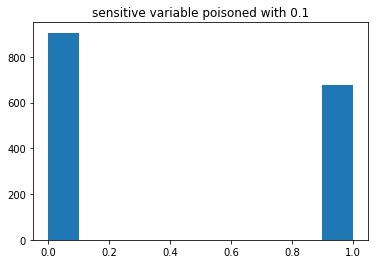

Overall accuracy: 0.625
disparate impact:  76.3590391908976
disparate misclassification rate:  80.0025611942483
disparate false positive rate: 95.99747208763428
disparate false negative rate: 91.51893808370805
equalized opportunity for 0.0 : 95.99747208763428
equalized opportunity for 1.0 : 82.4324929470243
loss function:  bce_loss
loss value for group 0: 0.6785091757774353
loss value for group 1: 0.627461314201355
poisoned ratio:  0.2


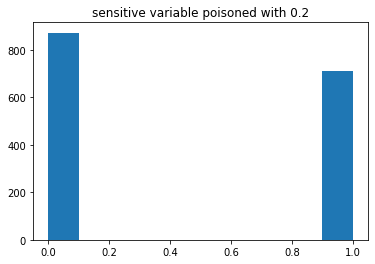

Overall accuracy: 0.625
disparate impact:  73.72095560161449
disparate misclassification rate:  81.43363914373087
disparate false positive rate: 90.21888871881218
disparate false negative rate: 89.67032051882619
equalized opportunity for 0.0 : 90.21888871881218
equalized opportunity for 1.0 : 78.8444728706961
loss function:  bce_loss
loss value for group 0: 0.6747421026229858
loss value for group 1: 0.6345126032829285
poisoned ratio:  0.3


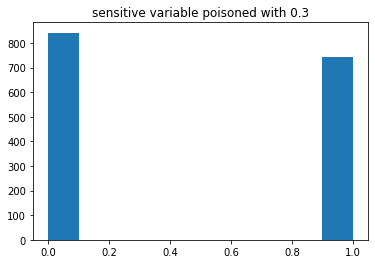

Overall accuracy: 0.625
disparate impact:  78.56106157992951
disparate misclassification rate:  86.03087259258332
disparate false positive rate: 85.00992063492063
disparate false negative rate: 92.26456471367098
equalized opportunity for 0.0 : 85.00992063492063
equalized opportunity for 1.0 : 84.20163096294418
loss function:  bce_loss
loss value for group 0: 0.6707639694213867
loss value for group 1: 0.6406534314155579


In [13]:
clf.eval()
print(len(xs_te))
for rt in [0.0,0.1,0.2,0.3]:
    print("="*20)
    print("poisoned ratio: ", rt)
    print("="*20)
    xs_tep =  poison_Z(xs_te,pos_rt =rt, rs = 3)
    plt.figure()
    plt.title('sensitive variable poisoned with '+str(rt))
    plt.hist(xs_tep.flatten())
    plt.show()

    _, testp_loader = make_dataloaders(X_tr, X_te, y_tr, y_te, xs_tr, xs_tep)
    test_FNN(clf, testp_loader,loss_fn = 'bce',thr = 0.5)

In [4]:
bank = pd.read_csv('../data/bank-full.csv')

In [5]:
print(bank)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd